In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [123]:
data= pd.read_csv("final_clv_dataset.csv")

In [124]:
data.head()

Customer ID  TotalSpend  PurchaseFrequency  OrderHabit  Recency  \
0        12346      169.36                  2        12.0      155   
1        12347      611.53                  1       509.0       30   
2        12348      222.16                  1       373.0       64   
3        12349     2671.14                  3       331.0       33   
4        12352      343.80                  2        94.0        1   

   AvgPurchaseGap  Tenure       Trend  Churn  ReturnRate       CLV  
0        5.130435     273  Increasing      1    0.428571  77183.60  
1        0.000000      30        Flag      0    0.000000   4085.18  
2        0.000000      64  Increasing      0    0.000000   1797.24  
3        1.782178     215  Increasing      0    0.005010   1757.55  
4        0.941176      18        Flag      0    0.000000   1665.74

In [125]:
data.shape

(2711, 11)

### Feature Overview

We have 9 input features and 1 target variable:
- **Customer ID** – Unique customer identifier
- **TotalSpend** – Total money spent in Year 1
- **PurchaseFrequency** – Number of distinct purchases
- **OrderHabit** – Avg quantity per invoice
- **Recency** – Days since last purchase in Year 1
- **Tenure** -
- **AvgPurchaseGap** – Avg days between two purchases
- **Trend** – Customer purchase behavior across 6 quarters
- **Churn** – Flag for early activity and late inactivity
- **ReturnRate** – Ratio of returned quantity to purchased quantity
- **CLV** (Target) – Total spend of that customer in Year 2


In [126]:
data=data.drop(columns=['Churn']) # Unreliable

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer ID        2711 non-null   int64  
 1   TotalSpend         2711 non-null   float64
 2   PurchaseFrequency  2711 non-null   int64  
 3   OrderHabit         2711 non-null   float64
 4   Recency            2711 non-null   int64  
 5   AvgPurchaseGap     2689 non-null   float64
 6   Tenure             2711 non-null   int64  
 7   Trend              2711 non-null   object 
 8   ReturnRate         2711 non-null   float64
 9   CLV                2711 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 211.9+ KB


In [128]:
data.shape

(2711, 10)

### After indepth practicing and rough work we decided to stick with tree based model
Since the tree model is unaffected by skewness will focus on creating good features and using them and not on transforming, then will label encode the categorical labels like 'Trend'--> after refinement of 'FLAG'

In [129]:
ndata=data.copy()

In [130]:
ndata['SpendPerOrder']=ndata['TotalSpend']/ndata['PurchaseFrequency']

In [131]:
ndata['SpendRate']=ndata['TotalSpend']/ndata['Tenure']

In [132]:
ndata['SpendPerItem']=ndata['SpendPerOrder']/ndata['OrderHabit']

In [133]:
ndata['Trend_Refined'] = ndata['Trend']

In [134]:
def classify_flag(s):
    return 'New Buyer' if s <= 600 else 'Seasonal Buyer'

mask = ndata['Trend'] == 'Flag'
ndata.loc[mask, 'Trend_Refined'] = ndata.loc[mask, 'TotalSpend'].apply(classify_flag)

In [135]:
ndata.groupby('Trend_Refined')['CLV'].mean()

Trend_Refined
Decreasing        2273.915602
Increasing        3026.119165
New Buyer          647.087701
Seasonal Buyer    2520.947899
Stable             725.921765
Name: CLV, dtype: float64

In [136]:
ndata=ndata.drop(columns=['Trend']) # Redundant of Trend_Refined

In [137]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer ID        2711 non-null   int64  
 1   TotalSpend         2711 non-null   float64
 2   PurchaseFrequency  2711 non-null   int64  
 3   OrderHabit         2711 non-null   float64
 4   Recency            2711 non-null   int64  
 5   AvgPurchaseGap     2689 non-null   float64
 6   Tenure             2711 non-null   int64  
 7   ReturnRate         2711 non-null   float64
 8   CLV                2711 non-null   float64
 9   SpendPerOrder      2711 non-null   float64
 10  SpendRate          2711 non-null   float64
 11  SpendPerItem       2711 non-null   float64
 12  Trend_Refined      2711 non-null   object 
dtypes: float64(8), int64(4), object(1)
memory usage: 275.5+ KB


> - Likely Reason for Nulls: Single purchase customers can’t have a "gap" — no second purchase to calculate a gap from
> - Impute nulls with a high constant (e.g., 365), representing customers who only purchased once → interpret as “long gap”.

In [138]:
ndata['AvgPurchaseGap'].fillna(365, inplace=True)

In [139]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer ID        2711 non-null   int64  
 1   TotalSpend         2711 non-null   float64
 2   PurchaseFrequency  2711 non-null   int64  
 3   OrderHabit         2711 non-null   float64
 4   Recency            2711 non-null   int64  
 5   AvgPurchaseGap     2711 non-null   float64
 6   Tenure             2711 non-null   int64  
 7   ReturnRate         2711 non-null   float64
 8   CLV                2711 non-null   float64
 9   SpendPerOrder      2711 non-null   float64
 10  SpendRate          2711 non-null   float64
 11  SpendPerItem       2711 non-null   float64
 12  Trend_Refined      2711 non-null   object 
dtypes: float64(8), int64(4), object(1)
memory usage: 275.5+ KB


## Feature Engineering:
- Feature Interaction Logics
- Composite feature creations
> These features are not directly used, but found after detailed analysis upn multiple iterations of data, can be seen in CLTV_Modeling_1

In [140]:
ndata=ndata.drop(columns=['Customer ID'])

In [141]:
ndata['EngagementScore'] = (ndata['PurchaseFrequency'] * ndata['SpendRate']) / (ndata['Tenure'] + 1)
#ndata['CustomerValue'] = ndata['TotalSpend'] * ndata['SpendRate']

In [142]:
ndata['ReturnImpact']=ndata['ReturnRate']*ndata['TotalSpend']
ndata['ReturnHabit']=ndata['ReturnRate']*ndata['OrderHabit']
ndata['ReturnPerDay']=ndata['ReturnRate']/ndata['Tenure']+1

In [143]:
ndata['RecencySpendRatio']=ndata['TotalSpend']/ndata['Recency']+1
ndata['RecentEngagement']=ndata['EngagementScore']/ndata['Recency']


In [144]:
ndata['GapEfficiency'] = ndata['TotalSpend'] / (ndata['AvgPurchaseGap'] + 1)
ndata['GapEngagement'] = ndata['EngagementScore'] / (ndata['AvgPurchaseGap'] + 1)
ndata['GapFrequencyRatio'] = ndata['PurchaseFrequency'] / (ndata['AvgPurchaseGap'] + 1)
ndata['GapHabitScore'] = ndata['OrderHabit'] / (ndata['AvgPurchaseGap'] + 1)

In [145]:
clv = ndata['CLV']
ndata = ndata.drop(columns=['CLV'])
ndata['CLV'] = clv
# Adds CLV in the end of the column...

In [146]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TotalSpend         2711 non-null   float64
 1   PurchaseFrequency  2711 non-null   int64  
 2   OrderHabit         2711 non-null   float64
 3   Recency            2711 non-null   int64  
 4   AvgPurchaseGap     2711 non-null   float64
 5   Tenure             2711 non-null   int64  
 6   ReturnRate         2711 non-null   float64
 7   SpendPerOrder      2711 non-null   float64
 8   SpendRate          2711 non-null   float64
 9   SpendPerItem       2711 non-null   float64
 10  Trend_Refined      2711 non-null   object 
 11  EngagementScore    2711 non-null   float64
 12  ReturnImpact       2711 non-null   float64
 13  ReturnHabit        2711 non-null   float64
 14  ReturnPerDay       2708 non-null   float64
 15  RecencySpendRatio  2711 non-null   float64
 16  RecentEngagement   2711 


 Correlation with CLV:
 CLV                  1.000000
TotalSpend           0.869920
GapEfficiency        0.854231
SpendRate            0.649084
RecencySpendRatio    0.568140
PurchaseFrequency    0.554702
GapFrequencyRatio    0.536292
SpendPerOrder        0.510423
ReturnImpact         0.492976
EngagementScore      0.387556
GapHabitScore        0.320552
GapEngagement        0.308911
OrderHabit           0.216330
RecentEngagement     0.119557
Tenure               0.103183
ReturnRate           0.052248
ReturnHabit          0.031887
ReturnPerDay         0.011136
SpendPerItem        -0.004100
AvgPurchaseGap      -0.024970
Recency             -0.099594
Name: CLV, dtype: float64


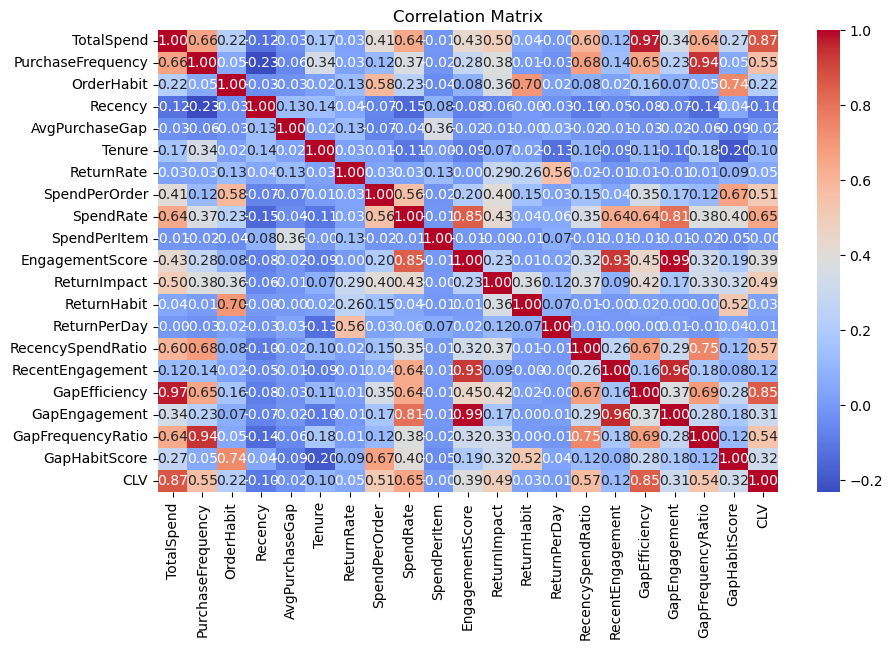

In [147]:
num_cols = ndata.select_dtypes(include='number').columns

# Correlation with CLV
correlation = ndata[num_cols].corr()['CLV'].sort_values(ascending=False)

print("\n Correlation with CLV:\n", correlation)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ndata[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Will drop :
- SpendPerItem
- AvgPurchaseGape
- Recency (Created RecencySegment showing better trend)

> why? Corr is -ve and these features been compositely used to create other features, thus have their taste left with other features...  

In [148]:
ndata = ndata.drop(columns=['SpendPerItem'])
ndata = ndata.drop(columns=['AvgPurchaseGap'])
ndata = ndata.drop(columns=['Recency'])


In [149]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TotalSpend         2711 non-null   float64
 1   PurchaseFrequency  2711 non-null   int64  
 2   OrderHabit         2711 non-null   float64
 3   Tenure             2711 non-null   int64  
 4   ReturnRate         2711 non-null   float64
 5   SpendPerOrder      2711 non-null   float64
 6   SpendRate          2711 non-null   float64
 7   Trend_Refined      2711 non-null   object 
 8   EngagementScore    2711 non-null   float64
 9   ReturnImpact       2711 non-null   float64
 10  ReturnHabit        2711 non-null   float64
 11  ReturnPerDay       2708 non-null   float64
 12  RecencySpendRatio  2711 non-null   float64
 13  RecentEngagement   2711 non-null   float64
 14  GapEfficiency      2711 non-null   float64
 15  GapEngagement      2711 non-null   float64
 16  GapFrequencyRatio  2711 

In [ ]:
# from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# # Define custom order for Trend_Refined
# trend_order = ['New Buyer', 'Stable', 'Seasonal Buyer', 'Decreasing', 'Increasing']
# #recency_order = ['Very Old', 'Old', 'Recent', 'Very Recent']

# encoder = OrdinalEncoder(categories=[trend_order])

# ndata['TrendEncoded'] = encoder.fit_transform(ndata['Trend_Refined'])

In [31]:
# Drop original categorical columns if no longer needed
# ndata.drop(['Trend_Refined'], axis=1, inplace=True)

In [151]:
ndata = ndata.drop(columns=['Trend_Refined'])

> `Recency_encoded` and `Trend_Refined` has been verified for their least impact in multiple runs, thus skipping label_encoding them and using them for further testing...


 Correlation with CLV:
 CLV                  1.000000
TotalSpend           0.869920
GapEfficiency        0.854231
SpendRate            0.649084
RecencySpendRatio    0.568140
PurchaseFrequency    0.554702
GapFrequencyRatio    0.536292
SpendPerOrder        0.510423
ReturnImpact         0.492976
EngagementScore      0.387556
GapHabitScore        0.320552
GapEngagement        0.308911
OrderHabit           0.216330
RecentEngagement     0.119557
Tenure               0.103183
ReturnRate           0.052248
ReturnHabit          0.031887
ReturnPerDay         0.011136
Name: CLV, dtype: float64


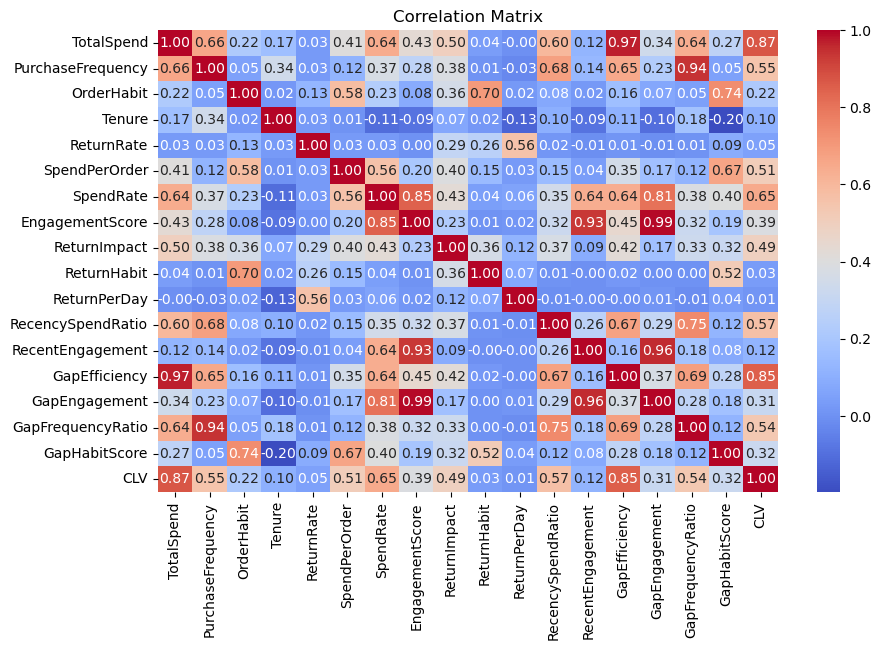

In [152]:
num_cols = ndata.select_dtypes(include='number').columns

# Correlation with CLV
correlation = ndata[num_cols].corr()['CLV'].sort_values(ascending=False)

print("\n Correlation with CLV:\n", correlation)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ndata[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [155]:
print(np.isinf(ndata).sum())   # Count of infinite values

TotalSpend            0
PurchaseFrequency     0
OrderHabit            0
Tenure                0
ReturnRate            0
SpendPerOrder         0
SpendRate             3
EngagementScore       3
ReturnImpact          0
ReturnHabit           0
ReturnPerDay          0
RecencySpendRatio    89
RecentEngagement     89
GapEfficiency         0
GapEngagement         3
GapFrequencyRatio     0
GapHabitScore         0
CLV                   0
dtype: int64


In [156]:
#Handling Infinie values
ndata= ndata.replace([np.inf, -np.inf], np.nan)
ndata = ndata.fillna(ndata.mean())

In [157]:
print(np.isinf(ndata).sum())

TotalSpend           0
PurchaseFrequency    0
OrderHabit           0
Tenure               0
ReturnRate           0
SpendPerOrder        0
SpendRate            0
EngagementScore      0
ReturnImpact         0
ReturnHabit          0
ReturnPerDay         0
RecencySpendRatio    0
RecentEngagement     0
GapEfficiency        0
GapEngagement        0
GapFrequencyRatio    0
GapHabitScore        0
CLV                  0
dtype: int64


## Base Model Selection
> We have already tried log transforming and fitting a `Linear Regression` model in our previous Notebook `CLTV_Modeling_1.ipynb` which suggested us Tree models are good so we will be trying `Tree-Based Regressor` only this time
----
### Model 1: Decision-Tree Regressor

In [158]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [159]:
X=ndata.drop(columns='CLV')
y=ndata['CLV']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [162]:
y_pred = model.predict(X_test)

In [163]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Base Decision Tree Regressor Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

Base Decision Tree Regressor Performance:
MAE:  1708.53
RMSE: 4642.41
R²:   0.7543


>  - Quite good R2 score, but D-Tree impose chances of `overfitting`, lets test it with ***Cross-Validation***

In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Average R²: {scores.mean():.4f}")


Cross-validated R² scores: [0.14729453 0.37645945 0.5797145  0.13150027 0.74400719]
Average R²: 0.3958


In [44]:
from sklearn.tree import DecisionTreeRegressor

model_limited = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)

model_limited.fit(X_train, y_train)
y_pred_limited = model_limited.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_limited)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_limited))
r2 = r2_score(y_test, y_pred_limited)

print("Regularized Decision Tree Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


Regularized Decision Tree Performance:
MAE:  1675.89
RMSE: 8271.40
R²:   0.2202


> #### Confirms Overfitting in D-Tree 
**Conclusion** Better we try `Ensembler models` 

### Model 2: Random-Forest Regressor
> Good Thing about Tree-Models, we dont need to transform, or care about outliers in data
>- sometime its better to apply Transformation or handle outlier(skewness) on target vallue, but in our case, already been tried, couldnt fine any sign of better performance, so not trying further

In [164]:
from sklearn.ensemble import RandomForestRegressor

In [165]:
X_trial=X.copy()

In [166]:
X_trial= X_trial.drop(columns=['ReturnRate', 'ReturnHabit', 'ReturnPerDay'])
# Low Corr

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_trial, y, test_size=0.2, random_state=42)

In [168]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [169]:
y_pred = rf.predict(X_test)

In [170]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

Random Forest Regressor Performance:
MAE:  1588.68
RMSE: 6523.01
R²:   0.5150


In [171]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-fold cross-validation R² scores
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))


Cross-validated R² scores: [0.73959222 0.36132867 0.59588039 0.46642161 0.50839653]
Average R²: 0.5343238834412214


### > Random-Forest is performing better

### > Feature Importance Graph

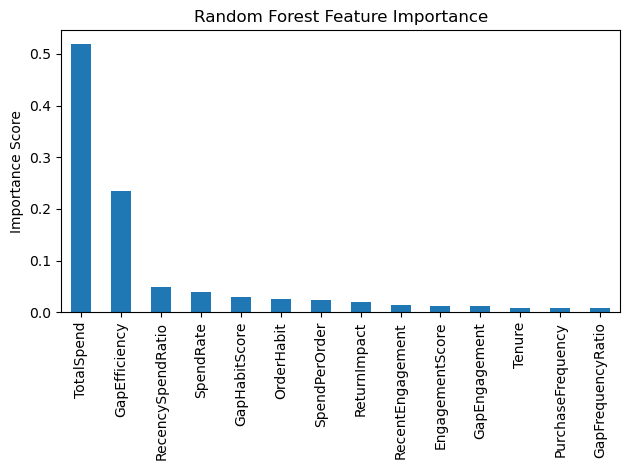

In [172]:
importances = rf.feature_importances_
features = X_trial.columns if hasattr(X, "columns") else [f"Feature {i}" for i in range(X.shape[1])]

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Random Forest Feature Importance')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


### Model 3: XGBoost Regressor

In [179]:
import xgboost as xgb

In [180]:
X_trial=X.copy()
X_trial= X_trial.drop(columns=['ReturnRate', 'ReturnHabit', 'ReturnPerDay'])
X_train, X_test, y_train, y_test = train_test_split(X_trial, y, test_size=0.2, random_state=42)

In [181]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.83,
    
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.83, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [182]:
y_pred = xgb_model.predict(X_test)

# Step 5: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Regressor Performance:")
print("MAE: ", mae)
print("RMSE:", rmse)
print("R²:  ", r2)

XGBoost Regressor Performance:
MAE:  1501.0120633807946
RMSE: 6347.126483454469
R²:   0.5407975831233871


> Lets Tune Parameter and find best R2 score based on Cross-Validation, using **`RandomizedSearchCSV`**

In [183]:
from sklearn.model_selection import RandomizedSearchCV

In [188]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'min_child_weight': [1, 3, 5, 10]
}

xgb_model = xgb.XGBRegressor(random_state=42)

# Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,  # increase for deeper search
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit the search on training data
random_search.fit(X_train, y_train)

# Best parameters
print("Best Params:", random_search.best_params_)

# Evaluate tuned model
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTuned XGBoost Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Optional: Cross-validated R²
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='r2')
print("\nCross-validated R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}

Tuned XGBoost Performance:
MAE:  1872.06
RMSE: 7797.24
R²:   0.3070

Cross-validated R² scores: [0.84513768 0.78242705 0.59810813 0.37726299 0.28436589]
Average R²: 0.5774603481518228


## SHAP Analysis--> To find how features are contributing...

In [63]:
import shap

In [64]:
shap.initjs()

In [65]:
# Create SHAP explainer
rf_explainer = shap.TreeExplainer(rf)  # Your trained Random Forest model
rf_shap_values = rf_explainer.shap_values(X)  # X = features used in training

SHAP Summary for Random Forest


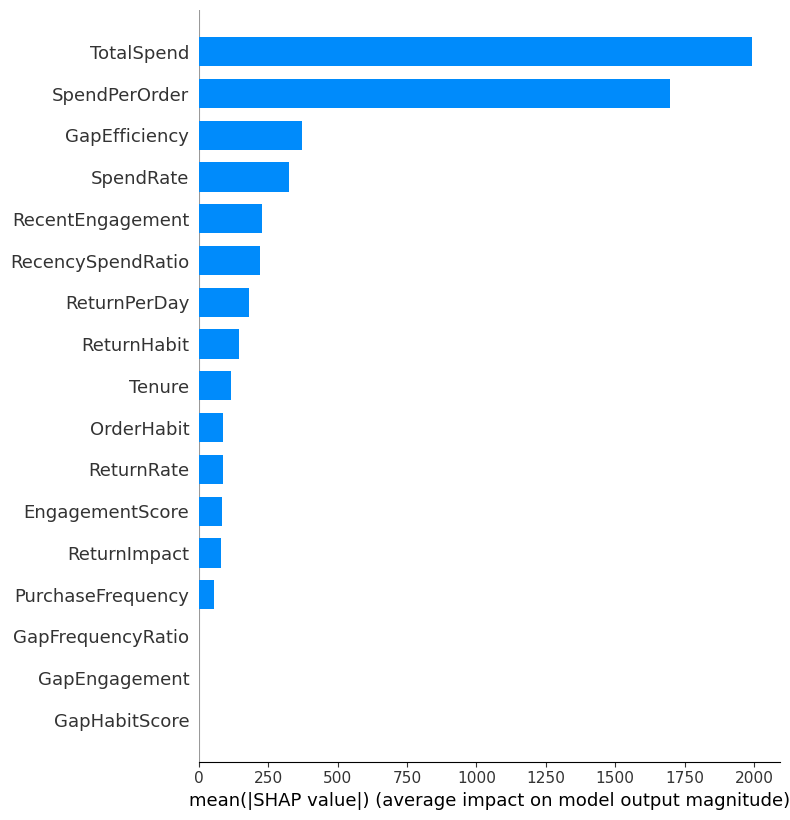

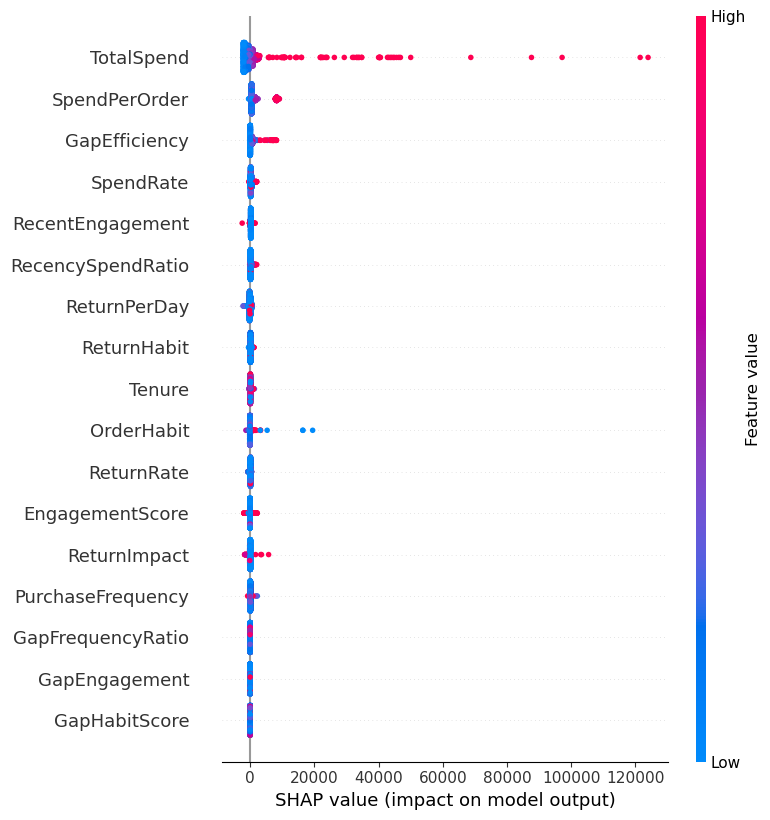

In [66]:
print("SHAP Summary for Random Forest")
shap.summary_plot(rf_shap_values, X, plot_type="bar")
shap.summary_plot(rf_shap_values, X)

In [86]:
X_trial=X.copy()
X_trial= X_trial.drop(columns=['ReturnRate', 'ReturnHabit', 'ReturnPerDay'])
X_train, X_test, y_train, y_test = train_test_split(X_trial, y, test_size=0.2, random_state=42)

# 2. Define and train the XGBoost model
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [87]:
xgb_explainer = shap.TreeExplainer(xgb_model)  # Your trained XGBoost model
xgb_shap_values = xgb_explainer.shap_values(X_trial)

SHAP Summary for XGBoost


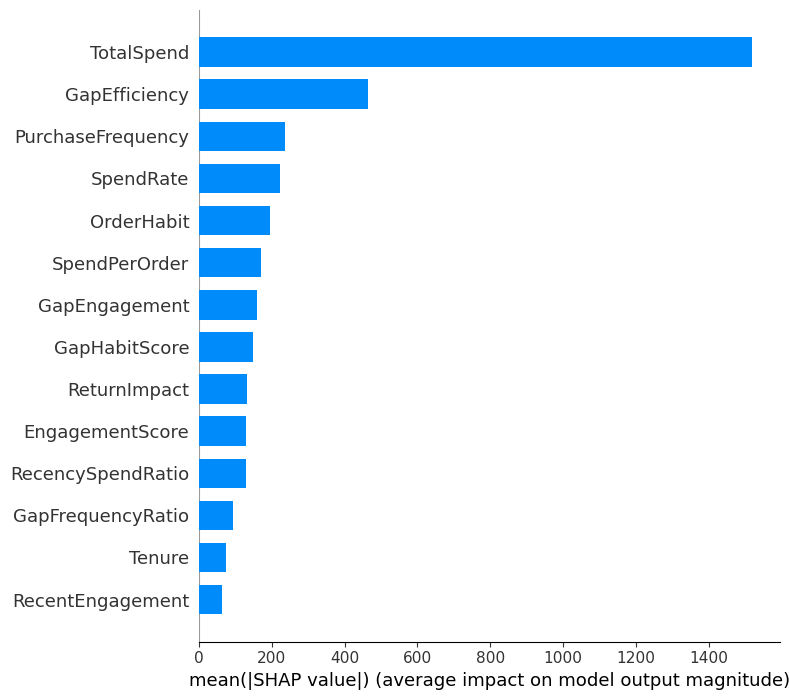

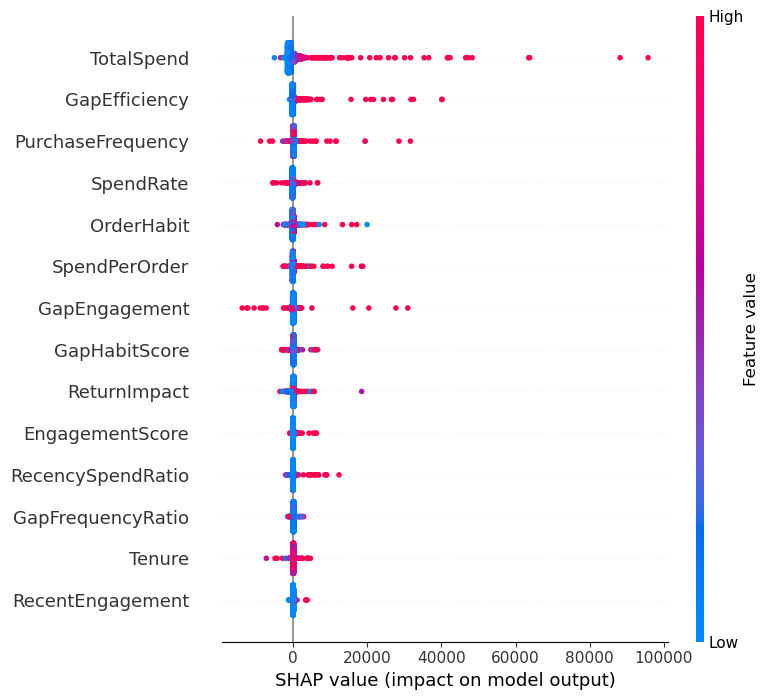

In [88]:
print("SHAP Summary for XGBoost")
shap.summary_plot(xgb_shap_values, X_trial, plot_type="bar")
shap.summary_plot(xgb_shap_values, X_trial)

In [89]:
# Force plot for a single prediction
shap.force_plot(rf_explainer.expected_value, rf_shap_values[0], X.iloc[0])


## > FINALISED Model: XGBoost

## > Observation:
- Different combination of features perform differently
- Feature selection is needed, but since it follows greedy logic and sequential selection, possibly wont able to get proper set
- lets apply `BruteForce` in finding out best set of features

In [185]:
from itertools import combinations

In [91]:
all_features = list(X_trial.columns)
results = []

# Try all feature combinations of length 3 to len(all_features)
for k in range(3, len(all_features)+1):
    for feature_combo in combinations(all_features, k):
        X_subset = X_trial[list(feature_combo)]
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results.append((feature_combo, r2))
        print(f"Features: {feature_combo} => R²: {r2:.4f}")

# Sort by best R²
results.sort(key=lambda x: x[1], reverse=True)

# Print Top 10 Feature Sets
#print("\nTop 10 Feature Combinations by R² Score:")
#for combo, score in results[:10]:
#    print(f"R²: {score:.4f} | Features: {combo}")

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit') => R²: -0.5993
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure') => R²: -0.8157
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder') => R²: -0.0417
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate') => R²: -0.0763
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore') => R²: -0.2526
Features: ('TotalSpend', 'PurchaseFrequency', 'ReturnImpact') => R²: 0.0822
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio') => R²: -0.5116
Features: ('TotalSpend', 'PurchaseFrequency', 'RecentEngagement') => R²: -0.5770
Features: ('TotalSpend', 'PurchaseFrequency', 'GapEfficiency') => R²: -0.7335
Features: ('TotalSpend', 'PurchaseFrequency', 'GapEngagement') => R²: -0.0999
Features: ('TotalSpend', 'PurchaseFrequency', 'GapFrequencyRatio') => R²: -0.7749
Features: ('TotalSpend', 'PurchaseFrequency', 'GapHabitScore') => R²: -0.2934
Features: ('TotalSpend', 'OrderHabit', 'Tenure') => R²: 0.2948
Feat

Features: ('PurchaseFrequency', 'SpendRate', 'GapEngagement') => R²: -0.5508
Features: ('PurchaseFrequency', 'SpendRate', 'GapFrequencyRatio') => R²: -0.4994
Features: ('PurchaseFrequency', 'SpendRate', 'GapHabitScore') => R²: -0.4723
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact') => R²: 0.0688
Features: ('PurchaseFrequency', 'EngagementScore', 'RecencySpendRatio') => R²: -0.9026
Features: ('PurchaseFrequency', 'EngagementScore', 'RecentEngagement') => R²: -0.3672
Features: ('PurchaseFrequency', 'EngagementScore', 'GapEfficiency') => R²: -0.1576
Features: ('PurchaseFrequency', 'EngagementScore', 'GapEngagement') => R²: -0.5181
Features: ('PurchaseFrequency', 'EngagementScore', 'GapFrequencyRatio') => R²: -0.7705
Features: ('PurchaseFrequency', 'EngagementScore', 'GapHabitScore') => R²: -0.4559
Features: ('PurchaseFrequency', 'ReturnImpact', 'RecencySpendRatio') => R²: -0.1115
Features: ('PurchaseFrequency', 'ReturnImpact', 'RecentEngagement') => R²: -0.1160
Features

Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.0430
Features: ('Tenure', 'ReturnImpact', 'RecentEngagement') => R²: 0.0630
Features: ('Tenure', 'ReturnImpact', 'GapEfficiency') => R²: 0.4821
Features: ('Tenure', 'ReturnImpact', 'GapEngagement') => R²: 0.2523
Features: ('Tenure', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.0208
Features: ('Tenure', 'ReturnImpact', 'GapHabitScore') => R²: 0.4100
Features: ('Tenure', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.0797
Features: ('Tenure', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.4354
Features: ('Tenure', 'RecencySpendRatio', 'GapEngagement') => R²: 0.0940
Features: ('Tenure', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.0197
Features: ('Tenure', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3315
Features: ('Tenure', 'RecentEngagement', 'GapEfficiency') => R²: 0.2556
Features: ('Tenure', 'RecentEngagement', 'GapEngagement') => R²: -0.0273
Features: ('Tenure', 'RecentEngagement', 'GapFrequencyRatio') =>

Features: ('ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.0579
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.1820
Features: ('ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.3236
Features: ('ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.3005
Features: ('ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2568
Features: ('ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.5461
Features: ('ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.1776
Features: ('ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2480
Features: ('ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.3967
Features: ('ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2626
Features: ('ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.6204
Features: ('ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4545
Features: ('RecencySpendRatio', 'RecentEngagement', 'GapEffi

Features: ('TotalSpend', 'PurchaseFrequency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2017
Features: ('TotalSpend', 'PurchaseFrequency', 'GapEngagement', 'GapHabitScore') => R²: 0.5334
Features: ('TotalSpend', 'PurchaseFrequency', 'GapFrequencyRatio', 'GapHabitScore') => R²: -0.0552
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder') => R²: 0.3079
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate') => R²: 0.5844
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore') => R²: 0.5681
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact') => R²: 0.5307
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'RecencySpendRatio') => R²: 0.4590
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'RecentEngagement') => R²: 0.4417
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'GapEfficiency') => R²: 0.5479
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'GapEngagement') => R²: 0.6604
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'GapFrequencyRat

Features: ('TotalSpend', 'Tenure', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.1294
Features: ('TotalSpend', 'Tenure', 'RecentEngagement', 'GapHabitScore') => R²: 0.6607
Features: ('TotalSpend', 'Tenure', 'GapEfficiency', 'GapEngagement') => R²: 0.5438
Features: ('TotalSpend', 'Tenure', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.1567
Features: ('TotalSpend', 'Tenure', 'GapEfficiency', 'GapHabitScore') => R²: 0.6724
Features: ('TotalSpend', 'Tenure', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4025
Features: ('TotalSpend', 'Tenure', 'GapEngagement', 'GapHabitScore') => R²: 0.7192
Features: ('TotalSpend', 'Tenure', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4837
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore') => R²: 0.5949
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'ReturnImpact') => R²: 0.7260
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio') => R²: 0.6925
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRa

Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.3865
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.3474
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.3903
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4599
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.6647
Features: ('TotalSpend', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.2937
Features: ('TotalSpend', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.3448
Features: ('TotalSpend', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3690
Features: ('TotalSpend', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.6907
Features: ('TotalSpend', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.3144
Features: ('TotalSpend', 'ReturnImpact', 'GapEfficiency', 'GapFrequ

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate') => R²: -0.1903
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore') => R²: 0.0857
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact') => R²: 0.1092
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio') => R²: -0.1869
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement') => R²: -0.1059
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'GapEfficiency') => R²: 0.0017
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'GapEngagement') => R²: 0.3460
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'GapFrequencyRatio') => R²: 0.2267
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'GapHabitScore') => R²: 0.0351
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore') => R²: -0.2514
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact') => R²: 0.3417
Featu

Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'RecentEngagement') => R²: 0.1815
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'GapEfficiency') => R²: 0.1166
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'GapEngagement') => R²: 0.0763
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'GapFrequencyRatio') => R²: -0.0945
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'GapHabitScore') => R²: 0.1014
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement') => R²: -0.5387
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency') => R²: -0.1609
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEngagement') => R²: 0.0396
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: -0.4210
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapHabitScore') => R²: -0.0772
Features: ('PurchaseFrequency', 'Spe

Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore') => R²: 0.6453
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact') => R²: 0.6902
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio') => R²: 0.6597
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement') => R²: 0.8347
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'GapEfficiency') => R²: 0.7827
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'GapEngagement') => R²: 0.7352
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'GapFrequencyRatio') => R²: 0.8765
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'GapHabitScore') => R²: 0.7044
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact') => R²: 0.6075
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio') => R²: 0.3755
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement') => R²: 0.5344
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'GapEfficiency') => R²: 0.7798
Features: 

Features: ('OrderHabit', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7946
Features: ('OrderHabit', 'SpendRate', 'GapEfficiency', 'GapHabitScore') => R²: 0.8041
Features: ('OrderHabit', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6373
Features: ('OrderHabit', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.6230
Features: ('OrderHabit', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8839
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.5238
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.7002
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.6932
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.7475
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.5887
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.5691
F

Features: ('Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapHabitScore') => R²: 0.3167
Features: ('Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement') => R²: 0.5444
Features: ('Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5042
Features: ('Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapHabitScore') => R²: 0.5541
Features: ('Tenure', 'SpendPerOrder', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5406
Features: ('Tenure', 'SpendPerOrder', 'GapEngagement', 'GapHabitScore') => R²: 0.3687
Features: ('Tenure', 'SpendPerOrder', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5317
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact') => R²: 0.3955
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio') => R²: 0.3815
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement') => R²: 0.2245
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'GapEfficiency') => R²: 0.4851
Features: ('Tenure', 'SpendRate', 'Engage

Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement') => R²: 0.1404
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency') => R²: 0.2758
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement') => R²: 0.3385
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio') => R²: 0.5839
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapHabitScore') => R²: 0.3752
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.3633
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement') => R²: 0.1400
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency') => R²: 0.2415
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement') => R²: 0.6620
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.4188
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapHabitScore') => R²: 0.5662

Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.5671
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.3341
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.1814
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: -0.0664
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.3343
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.0218
Features: ('SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: -0.0272
Features: ('SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement') => R²: 0.1819
Features: ('SpendRate', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2708
Features: ('SpendRate', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.2883
Features: ('SpendRate', 'EngagementScore', 'Ga

Features: ('ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2016
Features: ('ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4777
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.2546
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2215
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4229
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3597
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.4825
Features: ('ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2769
Features: ('ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.3326
Features: ('ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2267
Features: ('Retu

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecentEngagement', 'GapHabitScore') => R²: -0.0244
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'GapEfficiency', 'GapEngagement') => R²: 0.5516
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.0744
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'GapEfficiency', 'GapHabitScore') => R²: -0.0436
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5432
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'GapEngagement', 'GapHabitScore') => R²: 0.6263
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0680
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate') => R²: 0.3612
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore') => R²: 0.2465
Features: ('TotalSpe

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.2216
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency') => R²: 0.0304
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'RecentEngagement', 'GapEngagement') => R²: 0.4054
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2408
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'RecentEngagement', 'GapHabitScore') => R²: 0.1970
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement') => R²: 0.3160
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1147
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEfficiency', 'GapHabitScore') => R²: 0.2218
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEngagement', 'GapFreq

Features: ('TotalSpend', 'PurchaseFrequency', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5084
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: -0.3802
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.1613
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: -0.3716
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.1651
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.1356
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.2616
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: -0.1002
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySp

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapFrequencyRatio') => R²: 0.7380
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapHabitScore') => R²: 0.7593
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.4640
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement') => R²: 0.6239
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency') => R²: 0.7455
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEngagement') => R²: 0.7449
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.5741
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapHabitScore') => R²: 0.7069
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.5647
Features: ('TotalSpend', 'OrderHabit', 'Spen

Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.6495
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.5920
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5073
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.6881
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6397
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.7699
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6308
Features: ('TotalSpend', 'OrderHabit', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.5608
Features: ('TotalSpend', 'OrderHabit', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.4759
Features: ('TotalSpend', 'OrderHabit', 'Re

Features: ('TotalSpend', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEngagement') => R²: 0.5972
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6597
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapHabitScore') => R²: 0.8115
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.5627
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6162
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'GapEfficiency', 'GapHabitScore') => R²: 0.7774
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5165
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.6975
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7713
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.5568
Featur

Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.5801
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEngagement') => R²: 0.7129
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.7713
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.7736
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency') => R²: 0.6494
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement') => R²: 0.6484
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.8130
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapHabitScore') => R²: 0.7869
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.6222
Features: ('TotalSpend', 'SpendPerOrd

Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.2804
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.2729
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4857
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.5901
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: 0.2192
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement') => R²: 0.3505
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4985
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.7686
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement') => R²: 0.1775
Features: ('TotalSp

Features: ('TotalSpend', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.6489
Features: ('TotalSpend', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5987
Features: ('TotalSpend', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3091
Features: ('TotalSpend', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6927
Features: ('TotalSpend', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4553
Features: ('TotalSpend', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6561
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.3744
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3958
Features: ('TotalSpend', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRat

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapFrequencyRatio') => R²: -0.1010
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapHabitScore') => R²: -0.0583
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapEngagement') => R²: 0.6098
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.0790
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapHabitScore') => R²: 0.0263
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5662
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEngagement', 'GapHabitScore') => R²: 0.5674
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2015
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore') => R²: 0.3716
Features: ('PurchaseFrequency', 'Or

Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.5757
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.5229
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.4683
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.1405
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.1569
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4157
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.0933
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.0650
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'Re

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapEfficiency') => R²: -0.0457
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapEngagement') => R²: 0.0821
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.0926
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.1203
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency') => R²: 0.2172
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEngagement') => R²: 0.2637
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2786
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapHabitScore') => R²: 0.0904
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement') => R²: 0.4620


Features: ('PurchaseFrequency', 'Tenure', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.2081
Features: ('PurchaseFrequency', 'Tenure', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0311
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: -0.5864
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: -0.2778
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: -1.4419
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.4227
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.0977
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.3993
Features: ('PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScor

Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.1176
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.0790
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.0273
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.3230
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3214
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.0308
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.2544
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3827
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact',

Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.0155
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: -0.1388
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.0022
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.0233
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: -0.1942
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: -0.0258
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0278
Features: ('PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.0212
Features: ('PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'Gap

Features: ('PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.0936
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.4174
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: -0.3996
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: -0.1294
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.1177
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: -0.4863
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.0486
Features: ('PurchaseFrequency', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.2996
Features: ('Purcha

Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.6708
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.7724
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.6932
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.6776
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.6230
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.3617
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.6743
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.3750
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4434
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'Re

Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7104
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.4780
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8548
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.8095
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.8799
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.7903
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.7997
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.8867
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.8310
Features: ('OrderHabit',

Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6149
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.6210
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8135
Features: ('OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.6614
Features: ('OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.4958
Features: ('OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.7103
Features: ('OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.7283
Features: ('OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.8177
Features: ('OrderHabit', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.6094
Features: ('OrderHabit', 'SpendRate

Features: ('OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.6205
Features: ('OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5470
Features: ('OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.5783
Features: ('OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6520
Features: ('OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.7144
Features: ('OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4293
Features: ('OrderHabit', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.6748
Features: ('OrderHabit', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6542
Features: ('OrderHabit', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.79

Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6255
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.6311
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7205
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.1399
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.3250
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4799
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4085
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3980
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.4744
Features: ('Tenure', 'SpendPerOrder

Features: ('Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.1780
Features: ('Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1445
Features: ('Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4199
Features: ('Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2099
Features: ('Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.2581
Features: ('Tenure', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6774
Features: ('Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2710
Features: ('Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3280
Features: ('Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4849
Features: ('Tenure', 'SpendRate', 'RecentEngagement', 'GapEn

Features: ('Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3928
Features: ('Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5193
Features: ('Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2106
Features: ('Tenure', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3693
Features: ('Tenure', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4638
Features: ('Tenure', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5789
Features: ('Tenure', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1599
Features: ('Tenure', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4398
Features: ('Tenure', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6160
Features: ('Spend

Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.4603
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3975
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.6327
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6387
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.6914
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7484
Features: ('SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.2810
Features: ('SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3569
Features: ('SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagemen

Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.5730
Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7189
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.0674
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.2105
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2578
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.2523
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.0508
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2039
Features: ('SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabit

Features: ('EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4781
Features: ('EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5306
Features: ('EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2093
Features: ('EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2367
Features: ('EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3813
Features: ('EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.0949
Features: ('EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.1270
Features: ('EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4483
Features: ('EngagementScore', 'RecencySpendR

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.0793
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEfficiency') => R²: -0.0159
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEngagement') => R²: 0.3383
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.0238
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapHabitScore') => R²: 0.0260
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapEngagement') => R²: 0.3179
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.0175
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapHabitScore') => R²: 0.0245
Features: ('TotalSpend', 'Purc

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.4758
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4061
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'GapEfficiency', 'GapHabitScore') => R²: 0.4094
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4747
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.5752
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5551
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.3062
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.4339
Fea

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio') => R²: 0.3228
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement') => R²: 0.3690
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency') => R²: 0.3447
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEngagement') => R²: 0.3540
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapFrequencyRatio') => R²: 0.4087
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapHabitScore') => R²: 0.5145
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact') => R²: 0.4499
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio') => R²: 0.2533
Features: ('TotalSpend', 'PurchaseFreq

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.1736
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.1931
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.1428
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.2760
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: 0.2126
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEngagement') => R²: 0.2295
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.1468
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapHabitSc

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.5442
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.6025
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency') => R²: 0.4751
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement') => R²: 0.5311
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6220
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapHabitScore') => R²: 0.6428
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.3555
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapFrequen

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4197
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4228
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2745
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5098
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.3357
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.3139
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.2638
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 

Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3941
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.2390
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.2515
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2039
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.4575
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.1626
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1392
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnI

Features: ('TotalSpend', 'PurchaseFrequency', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4161
Features: ('TotalSpend', 'PurchaseFrequency', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3806
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore') => R²: 0.6087
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact') => R²: 0.6579
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio') => R²: 0.5231
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement') => R²: 0.6486
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency') => R²: 0.5757
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEngagement') => R²: 0.6148
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder',

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.6036
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.5930
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.6517
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: 0.6355
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEngagement') => R²: 0.5686
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6346
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.6880
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'EngagementScore', 'GapEfficiency', 'GapEngagement') => R²: 0.6749
Features: ('TotalSpend', 'OrderHabit', '

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapHabitScore') => R²: 0.7585
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7009
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.7374
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8130
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.5688
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.6475
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.6391
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.6684
Features: ('TotalSpend', 'Ord

Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.5734
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4818
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.7051
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.7354
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: 0.5213
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement') => R²: 0.4208
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7023
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.8337
Features: ('

Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.3962
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3217
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.5931
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4993
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.6063
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6857
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5200
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapF

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.7617
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency') => R²: 0.6122
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement') => R²: 0.6880
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7049
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapHabitScore') => R²: 0.7470
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.6357
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6449
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapHabitScore') => R²: 0.7127
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEng

Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.5143
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.5306
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.5736
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.7153
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.4291
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.4294
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4642
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.5541
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'Engageme

Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.3844
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3397
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6026
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4745
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.6116
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5845
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5000
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4527
Fe

Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5558
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapHabitScore') => R²: 0.6975
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5653
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.7027
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8155
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.6698
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.5766
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.6135
Featur

Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5338
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6134
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5766
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7409
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7016
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5593
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7189
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapFrequ

Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3823
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.5694
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7374
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2254
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2128
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5816
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3689
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitSco

Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6947
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2902
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3230
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5375
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3789
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.5361
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6122
Features: ('TotalSpend', 'EngagementScore', 'RecencySpendRati

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3763
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapHabitScore') => R²: 0.3296
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6944
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'GapEngagement', 'GapHabitScore') => R²: 0.5641
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2300
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact') => R²: 0.1317
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio') => R²: -0.0865
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement') => R²: 0.0282
Features: ('Purchas

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: -0.3031
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: -0.1588
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: -0.4796
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.2460
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.2323
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.1820
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: -0.1683
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapEngagement', 'GapF

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5766
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapHabitScore') => R²: 0.4544
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5821
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.5152
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5050
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.2831
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.3153
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImp

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.2920
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.2826
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.2936
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2430
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.3582
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.3877
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4222
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²:

Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5257
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2395
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3183
Features: ('PurchaseFrequency', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.1113
Features: ('PurchaseFrequency', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.2260
Features: ('PurchaseFrequency', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.0411
Features: ('PurchaseFrequency', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.1231
Features: ('PurchaseFrequency', 'OrderHabit', 'ReturnImpact',

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.3776
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5288
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.1165
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.2589
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.3131
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.2157
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.3555
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.

Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: -0.1216
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.0467
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: 0.0179
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement') => R²: -0.2187
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio') => R²: -0.0398
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.1547
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement') => R²: -0.2145
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio') =>

Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.2097
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: -0.0909
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: -0.3021
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: -0.2279
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: -0.4443
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: -0.0158
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.1911
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentE

Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.1841
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement') => R²: 0.0244
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2099
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapHabitScore') => R²: 0.2198
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1934
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.2478
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3668
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'Rec

Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1192
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.1699
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2324
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2401
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2382
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3526
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2011
Features: ('PurchaseFrequency

Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: -0.0689
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: -0.3335
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.3122
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: -0.1278
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.1181
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.1000
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: -0.1229
Features: ('PurchaseFrequency', 'SpendRate

Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: -0.0051
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1480
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1456
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3604
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1109
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.3941
Features: ('PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1373
Features: ('PurchaseFrequency', 'Enga

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.7181
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.6351
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency') => R²: 0.6680
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement') => R²: 0.6735
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7480
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapHabitScore') => R²: 0.6320
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.7411
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7355
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate',

Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.6676
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.6876
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.7288
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.5634
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.4937
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4568
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.6164
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.6169
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'Eng

Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4220
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.3818
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4926
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5287
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.5742
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3919
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.4352
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0

Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapHabitScore') => R²: 0.6431
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement') => R²: 0.6154
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7289
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapHabitScore') => R²: 0.7059
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6835
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.6816
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8427
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.7073
Featu

Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7695
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.7927
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7908
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.4569
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8183
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7502
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7678
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapFrequ

Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6738
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.7312
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4397
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.7534
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8662
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5902
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6965
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitS

Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7267
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7033
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6977
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7682
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7636
Features: ('OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5815
Features: ('OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5743
Features: ('OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', '

Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.5624
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6207
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.6059
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.4327
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5795
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.5439
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5916
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.6923
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnI

Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4365
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3785
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4245
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3702
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.4861
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3821
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5410
Features: ('Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4810
Fe

Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3258
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3129
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4505
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.3063
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3508
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4280
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4164
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.5253
Features: ('Tenure', 'Spend

Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.3331
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1808
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4844
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2799
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.4079
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4387
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2267
Features: ('Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScor

Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5645
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.7128
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5798
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7622
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6867
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3540
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4571
Features: ('SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => 

Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3637
Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.4858
Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3510
Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2129
Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4609
Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4249
Features: ('SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6510
Features: ('SpendPerOrder', 'ReturnImpact', 'RecentEngagement

Features: ('SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2395
Features: ('SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3321
Features: ('SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4751
Features: ('SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6137
Features: ('SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4208
Features: ('SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1129
Features: ('SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.1716
Features: ('SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRat

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.3101
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4593
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4740
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3983
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency') => R²: 0.4146
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEngagement') => R²: 0.5859
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.5339
Features: ('TotalSpend

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5036
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.5717
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4924
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.3235
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.2716
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.5570
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.2581
Features: ('TotalSpend

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapHabitScore') => R²: 0.6257
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement') => R²: 0.6281
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6712
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapHabitScore') => R²: 0.6257
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6946
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapHabitScore') => R²: 0.6684
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7314
Features: ('TotalSp

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5619
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6144
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4960
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6957
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R²: 0.4522
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement') => R²: 0.6205
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.5

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.3940
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4954
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4719
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3970
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.5763
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.5720
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', '

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.3792
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0190
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3615
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4532
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0255
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3789
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'RecentEngagement', 'GapEfficiency', 'GapE

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.1789
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.3055
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.3989
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3654
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.2806
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.4014
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4367
Features

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3483
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.4908
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.2567
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2432
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.3702
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3654
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.5871
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenu

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3356
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4008
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3829
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.0174
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3257
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.0792
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²:

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.3601
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.5329
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4829
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.4567
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.4907
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.5802
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') =

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.5740
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5733
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4805
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4104
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5271
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5554
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'Rec

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.2363
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2730
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.4328
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3758
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.5776
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5330
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') 

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.0622
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4313
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3053
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4998
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3360
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.1705
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngag

Features: ('TotalSpend', 'PurchaseFrequency', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3798
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1786
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3863
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: -0.1815
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3502
Features: ('TotalSpend', 'PurchaseFrequency', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2998
Features: ('TotalSpend', 'PurchaseFrequency', 'RecentEngagement', 'GapEfficien

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.6737
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.6930
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6096
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.6176
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.7569
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6893
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.6838
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'Ret

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.6898
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6920
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.6806
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.6274
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7133
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7375
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4800
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpe

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6495
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5785
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.6382
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6345
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.7098
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6403
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6826
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'Ret

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.7256
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7132
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.6185
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.6188
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7479
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7539
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.6166
Features: ('TotalSpend',

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.7897
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6259
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.6463
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.5904
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5970
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6945
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²:

Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4576
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7004
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.7780
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6745
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7669
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8771
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5791
Features: ('To

Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7739
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6579
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7275
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7255
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6924
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5197
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') =>

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapHabitScore') => R²: 0.6019
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5606
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.6293
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7569
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.5406
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.5762
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.6910
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.5680
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7515
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4992
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5081
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6207
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6229
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.6468
Features: ('T

Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.6841
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7071
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.4290
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.4171
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.5991
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7490
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.3373
Features: ('TotalSpend', 'Tenure', 'Sp

Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4832
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5455
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6594
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5205
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.6559
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6453
Features: ('TotalSpend', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5109
Features: ('Tota

Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7517
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.8261
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.6209
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6136
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.7177
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6647
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.7709
Features: ('Tota

Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6428
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7910
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6620
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.4481
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5807
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.5058
Features: ('TotalSpend', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'G

Features: ('TotalSpend', 'SpendPerOrder', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6212
Features: ('TotalSpend', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6575
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.5200
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5173
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6903
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7565
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEnga

Features: ('TotalSpend', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5217
Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2944
Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3809
Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6139
Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3797
Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.6246
Features: ('TotalSpend', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'G

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency') => R²: 0.5134
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEngagement') => R²: 0.5816
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.6192
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.4997
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.1314
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.2452
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.3649
Featu

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio') => R²: 0.3632
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapHabitScore') => R²: 0.4271
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.3267
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.2685
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.3552
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.2814
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.2380
Features: ('Purchas

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4849
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.5442
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.6121
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5499
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.4963
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5097
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.5549
Features:

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2059
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5746
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6396
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1049
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4743
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6498
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio') => R

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4800
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4701
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5856
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5859
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7069
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.5881
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'Gap

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5540
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6510
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5856
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6258
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6582
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5146
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapE

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3844
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4704
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4343
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3940
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.3674
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4722
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapH

Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4774
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5750
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4184
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2527
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5816
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6529
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecentEngageme

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.2816
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.4442
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3675
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.3101
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.3203
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3462
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.2795
Features: ('PurchaseFrequenc

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3759
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4277
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.2927
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4233
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4898
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5624
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio', 'G

Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: -0.0225
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.1856
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: -0.1146
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: -0.0872
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.1373
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.1016
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequ

Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1347
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.2451
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1303
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.3231
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1921
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2304
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency',

Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.3609
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.4898
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4999
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.5821
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.2708
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3327
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficienc

Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1519
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3128
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3359
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3991
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3081
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3636
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency',

Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3729
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4221
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4372
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4561
Features: ('PurchaseFrequency', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3248
Features: ('PurchaseFrequency', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3857
Features: ('PurchaseFrequency', 'SpendPerOrder', 'RecencySpendRatio', 'Recent

Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0950
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.0787
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.2010
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3302
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1889
Features: ('PurchaseFrequency', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3218
Features: ('PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'Ga

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6762
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.6358
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7901
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.7166
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.6504
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.7766
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.7320
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'Spen

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.6769
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7133
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6819
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6788
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.6212
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7417
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7817
Features: ('Or

Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5288
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6428
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.5742
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.5756
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6176
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6220
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5005
Features: ('OrderHabit', 'T

Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6154
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.7210
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7272
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.7551
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6870
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7430
Features: ('OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6708
Features: ('Order

Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.8287
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8651
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.6395
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.7621
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6541
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.8148
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => 

Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.8399
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.8164
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7684
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.7412
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6986
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6572
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngag

Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.8349
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.6162
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7592
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.7629
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7164
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.8054
Features: ('OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²

Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7524
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7246
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7084
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6960
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6778
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7173
Features: ('OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapE

Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4805
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.6175
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4835
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3845
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4178
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5528
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.5214
Features: ('Tenure', 'SpendPer

Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5557
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5722
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5114
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5724
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6457
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6056
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore

Features: ('Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3475
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4200
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5431
Features: ('Tenure', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4841
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2488
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3102
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5642
Features: ('Tenure

Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6557
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.6929
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7661
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4218
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6133
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5347
Features: ('SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFreq

Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5408
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4158
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5102
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5351
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6898
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6106
Features: ('SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngage

Features: ('ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3737
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact') => R²: 0.5882
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio') => R²: 0.4723
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement') => R²: 0.6128
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency') => R²: 0.5479
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement') => R²: 0.6361
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'Sp

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.4655
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.6239
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.5098
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.5449
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.5290
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4754
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'Spe

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3321
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.5170
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.5229
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4441
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.4596
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.4873
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact',

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.3897
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2756
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4873
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4446
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4711
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5137
Features: ('TotalSpend', 'PurchaseFrequency'

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.5798
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.4783
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement') => R²: 0.5378
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.5686
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.5526
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency') => R²: 0.5712
Features: ('TotalSpend', 'Pu

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.5112
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.5306
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.5495
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.5844
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.6826
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6801
Features: (

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5851
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6660
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4531
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2685
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: -0.0199
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4703
Fea

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.4899
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5414
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4944
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4837
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4424
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5630
Features: ('TotalSpend', 'Purcha

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5422
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5919
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.3226
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2526
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3229
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²:

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement') => R²: 0.2391
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.2673
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapHabitScore') => R²: 0.4610
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4786
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEngagement', 'GapHabitScore') => R²: 0.6191
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5572
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6559
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.2529
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3205
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.3188
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4896
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.2583
Features: ('TotalSp

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4880
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3077
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4940
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5125
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.3364
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.2143
Features: ('TotalSpend', 'PurchaseFrequency'

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4866
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2788
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4600
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4749
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6533
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1474
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'Rec

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3405
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5161
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4845
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.0933
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.0363
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.0353
Features: ('TotalSpend',

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4543
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5167
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.5630
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5803
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4441
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5678
Features: ('Tota

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.4451
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3558
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.3296
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3254
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4408
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.1331
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4268
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.1696
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1748
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4201
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2854
Feat

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2241
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4118
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2788
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4689
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1881
Features: ('TotalSpend', 'PurchaseFrequency', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') =

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7511
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.6374
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.6018
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.6121
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.6501
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.7323
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngage

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6361
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5744
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.6029
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6632
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.6680
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6854
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7879
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.8488
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement') => R²: 0.7325
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.7705
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapHabitScore') => R²: 0.7715
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7270
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement'

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7724
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6583
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6825
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7360
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7845
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7328
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'GapEfficiency', 'GapEngagement', 

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7492
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7476
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7825
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7733
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5701
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6534
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'Recent

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7654
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.7239
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.8192
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.8346
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.8261
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.8428
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6791
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6266
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7140
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7580
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7243
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7274
Features: ('TotalS

Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5955
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6732
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7219
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6510
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6283
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7732
Features: ('TotalSpend', 'OrderHabit', 'Spen

Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6857
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6489
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7005
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6633
Features: ('TotalSpend', 'OrderHabit', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7364
Features: ('TotalSpend', 'OrderHabit', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6172
Features: ('TotalSpe

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7999
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7911
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7804
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6426
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7180
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7225
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', '

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6326
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6143
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6169
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4422
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4294
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5590
Features: ('TotalSpend', 'Tenure', 'SpendPerOrde

Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5964
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4638
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6749
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6540
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6452
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5923
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'ReturnImpact', 'Recen

Features: ('TotalSpend', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6706
Features: ('TotalSpend', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5777
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.6519
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.6921
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7293
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7165
Features: ('TotalSpend', 'Spe

Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6726
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5041
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6653
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6149
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7143
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5845
Features: ('TotalSpend', 

Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3385
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6088
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6537
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6145
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6006
Features: ('TotalSpend', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6022
Features:

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6988
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.7008
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5582
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.4282
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3763
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2984
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPe

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6939
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7136
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5282
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6620
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.4731
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.4715
Features: ('PurchaseFrequency', 'Order

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.3628
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3433
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2674
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.3244
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4054
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3108
Features: ('PurchaseFrequency', 'Order

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6033
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.5849
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.6335
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.5119
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4730
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.5427
Features: ('PurchaseFrequency

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4704
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4852
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2479
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3759
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4115
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6354
Features: ('Pur

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5970
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6956
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5850
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7540
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7869
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4090
Features: ('PurchaseFrequenc

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5748
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5959
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5195
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4144
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7141
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabit

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3757
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3980
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2763
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.3325
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4384
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio')

Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5620
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4445
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4360
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4993
Features: ('PurchaseFrequency', 'OrderHabit', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7156
Features: ('PurchaseFrequency', 'OrderHabit', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement',

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.0465
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1862
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.2094
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4429
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.4813
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4076
Features: ('PurchaseFrequency', 'Tenure', 'Spe

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1447
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1929
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.2621
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1350
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.2549
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') 

Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5454
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2228
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4277
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3596
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5253
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: -0.0009
Features: ('PurchaseFrequency', 'Tenure', 

Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2620
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5294
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3630
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5554
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4847
Features: ('PurchaseFrequency', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1307
Featur

Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4123
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3462
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1642
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.0550
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.1684
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') =

Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3782
Features: ('PurchaseFrequency', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5683
Features: ('PurchaseFrequency', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4881
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.0552
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: -0.0016
Features: ('PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7326
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapHabitScore') => R²: 0.8110
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7901
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.5446
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5648
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6173
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'Engagement

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7383
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6920
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6580
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.7371
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.7464
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7617
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'Engagem

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5244
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5148
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4681
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5191
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7032
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.6157
Features: ('OrderHabit', 'Tenure', 'SpendRate'

Features: ('OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7516
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5962
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3847
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4527
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4939
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5271
Features: ('OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 

Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7213
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8552
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5472
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6170
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5755
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5411
Features: ('OrderHabit

Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7271
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4762
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5520
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5448
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6394
Features: ('OrderHabit', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => 

Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.5338
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5144
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6293
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.5501
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4676
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5030
Features: ('Tenure', 'SpendPerOrder', 'SpendRate',

Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6042
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3507
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4482
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4962
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4977
Features: ('Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5599
Features: ('Tenure', 'SpendPerOrde

Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2603
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3180
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3728
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4992
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3719
Features: ('Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4150
Features: ('Tenure', 'SpendRate', 'RecencySpendRati

Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3691
Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4711
Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4834
Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5861
Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3760
Features: ('SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.44

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.3783
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4469
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.4618
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3717
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4257
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequen

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.4389
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4053
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4565
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4116
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3745
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio',

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.4214
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4159
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4569
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.2621
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1445
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapE

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4175
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5202
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4267
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6617
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5545
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', '

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3164
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4280
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4795
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5530
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4436
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'Gap

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.5267
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.5173
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6123
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.6133
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.4386
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'Re

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5982
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.6143
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6427
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5644
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5865
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore'

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.4658
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.5161
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.3208
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3568
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.4417
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnIm

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2956
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4069
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4607
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4608
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3816
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'RecentEngagement',

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5473
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.1605
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.3522
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.2629
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.4415
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySp

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4373
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3766
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4998
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3239
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4577
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFre

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3028
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2245
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3893
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2184
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4654
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4135
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4874
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3680
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.2154
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.0763
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagem

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4638
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3264
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4546
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4174
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.3677
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3032
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4875
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4203
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4804
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4133
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'Re

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3986
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3734
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.5170
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5155
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1437
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendRate', 'EngagementScore'

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7373
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency') => R²: 0.6132
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement') => R²: 0.6262
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.6919
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.7284
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7052
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6840
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6932
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7627
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7621
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.728

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6311
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6097
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7321
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6962
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7259
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitS

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6496
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.7515
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5479
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7128
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7252
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio')

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.7457
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapHabitScore') => R²: 0.6320
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.6052
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6769
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.6456
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRati

Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6813
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5967
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6385
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6762
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7556
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngage

Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7851
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7904
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7715
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4540
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5875
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapE

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6365
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3776
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5521
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4939
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5844
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngage

Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6310
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6096
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5706
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6556
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5056
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagemen

Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5914
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6945
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6349
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.7003
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6777
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'Re

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.4272
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency') => R²: 0.5177
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement') => R²: 0.5178
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio') => R²: 0.5680
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapHabitScore') => R²: 0.4772
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5989
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6658
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5858
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.3999
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.3735
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEffici

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6524
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6303
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6779
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6141
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7475
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpend

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.2289
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1492
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.1836
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1082
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.3393
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4776
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5174
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3994
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3005
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4053
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'Recent

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5992
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5482
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6370
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4459
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4940
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'ReturnIm

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4306
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2921
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4907
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6926
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5039
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'E

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.2575
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.1234
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.1761
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1744
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1487
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'Recen

Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2373
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1937
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4637
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.1253
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.1010
Features: ('PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact

Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2455
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: -0.0647
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.1087
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.0888
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: -0.0007
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRat

Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3237
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2744
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3395
Features: ('PurchaseFrequency', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1492
Features: ('PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2593
Features: ('PurchaseFrequency', 'SpendPerOrder', 'Engagement

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4306
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4671
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4937
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6056
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7477
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7467
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6539
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7194
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6502
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7409
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngag

Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.8816
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.8650
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7226
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7244
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7509
Features: ('OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpen

Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4384
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4262
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5916
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5150
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5680
Features: ('Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFre

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement') => R²: 0.4558
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency') => R²: 0.4405
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement') => R²: 0.4274
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio') => R²: 0.4418
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapHabitScore') => R²: 0.3775
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit'

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4722
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5544
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4410
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5100
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5679
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5244
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4313
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3629
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4793
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.4821
Features: ('Total

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapHabitScore') => R²: 0.5021
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5586
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4256
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4522
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5162
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4243
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3606
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4204
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5013
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4259
Features: ('TotalSpend', 'PurchaseFr

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5770
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5859
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.6481
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6510
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4455
Features: ('TotalSpend', '

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4761
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5329
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4791
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5213
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') =

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5593
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4434
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4999
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3179
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5341
Fe

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.0769
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.0234
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.3429
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2133
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.4582
Features: ('TotalSpend

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3798
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2908
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3664
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4584
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5217
Features: ('TotalS

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4786
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3992
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4212
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2390
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.2382
Features: ('TotalSpend', 

Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3915
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3495
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4651
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4326
Features: ('TotalSpend', 'PurchaseFrequency', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'G

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6709
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6977
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.7177
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6927
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7530
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'S

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6621
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6240
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6856
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7509
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6570
Features: ('TotalSpend', 'OrderHabi

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6882
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.6312
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.6751
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.6513
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.7152
Features: ('TotalSpend', 'Or

Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7099
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6373
Features: ('TotalSpend', 'OrderHabit', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6549
Features: ('TotalSpend', 'OrderHabit', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6613
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4689
Features: ('TotalSpend',

Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6884
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6346
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6671
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5814
Features: ('TotalSpend', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5999
Features: ('TotalSpend', 'Tenure', 'Engagem

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4949
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5075
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3864
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6082
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6438
Features: ('PurchaseFrequency', 'Or

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5010
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5040
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4776
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6011
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7122
F

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5149
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6232
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7235
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5274
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5807
Fea

Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4912
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4658
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5639
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6761
Features: ('PurchaseFrequency', 'OrderHabit', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') 

Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.1720
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2076
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2400
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2250
Features: ('PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3686
Features: (

Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.7787
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6614
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6338
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.6794
Features: ('OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6503
Features: ('OrderHabit', 'Tenure',

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement') => R²: 0.5033
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5403
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapHabitScore') => R²: 0.5345
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.6472
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'Ga

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.5288
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5357
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6655
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5558
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequenc

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4796
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5275
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5764
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapHabitScore') => R²: 0.5851
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapF

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4431
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.4842
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5235
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6622
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement',

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.3094
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4001
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.5254
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.4553
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEng

Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4709
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.2645
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3401
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.1865
Features: ('TotalSpend', 'PurchaseFrequency', 'Tenure', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEng

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6933
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5810
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6515
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5807
Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFreque

Features: ('TotalSpend', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5384
Features: ('TotalSpend', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5316
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.5296
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.5282
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'Recent

Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapHabitScore') => R²: 0.3576
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3521
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3236
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.3176
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngage

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement') => R²: 0.4317
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapFrequencyRatio') => R²: 0.4254
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapHabitScore') => R²: 0.4549
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5737
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRat

Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5103
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4820
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5967
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.4977
Features: ('TotalSpend', 'PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendRate', 'ReturnImpa

Features: ('TotalSpend', 'OrderHabit', 'Tenure', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5853
Features: ('TotalSpend', 'OrderHabit', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.6150
Features: ('TotalSpend', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio', 'GapHabitScore') => R²: 0.5613
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', 'EngagementScore', 'ReturnImpact', 'RecencySpendRatio', 'RecentEngagement', 'GapEfficiency', 'GapEngagement', 'GapFrequencyRatio') => R²: 0.5315
Features: ('PurchaseFrequency', 'OrderHabit', 'Tenure', 'SpendPerOrder', 'SpendRate', '

In [190]:
print("\n" + "="*70)
print(" Top 10 Feature Combinations by R² Score")
print("="*70)
for i, (combo, score) in enumerate(results[:10], 1):
    features = ", ".join(combo)
    print(f"{i}. R²: {score:.4f}")
    print(f"   Features: {features}\n")



 Top 10 Feature Combinations by R² Score
1. R²: 0.9087
   Features: OrderHabit, SpendPerOrder, SpendRate, ReturnImpact, RecencySpendRatio, RecentEngagement, GapEngagement, GapHabitScore

2. R²: 0.9040
   Features: OrderHabit, SpendPerOrder, SpendRate, RecencySpendRatio, GapFrequencyRatio, GapHabitScore

3. R²: 0.9032
   Features: TotalSpend, OrderHabit, SpendRate, RecentEngagement, GapFrequencyRatio, GapHabitScore

4. R²: 0.8956
   Features: OrderHabit, SpendPerOrder, EngagementScore, ReturnImpact, RecencySpendRatio, RecentEngagement, GapEngagement, GapHabitScore

5. R²: 0.8921
   Features: OrderHabit, SpendPerOrder, SpendRate, EngagementScore, ReturnImpact, RecencySpendRatio, RecentEngagement, GapEngagement, GapFrequencyRatio

6. R²: 0.8916
   Features: OrderHabit, SpendRate, RecentEngagement, GapFrequencyRatio

7. R²: 0.8910
   Features: OrderHabit, Tenure, SpendPerOrder, EngagementScore, ReturnImpact, RecentEngagement, GapFrequencyRatio

8. R²: 0.8903
   Features: OrderHabit, Spend

> Lets Analyze group and analyse based on **featureSet Size**

In [97]:
from collections import defaultdict

grouped_results = defaultdict(list)

# Group results by number of features
for combo, score in results:
    grouped_results[len(combo)].append((combo, score))

# Nicely formatted output
for k in sorted(grouped_results.keys()):
    print("=" * 60)
    print(f"Top 3 Combinations with {k} Features".center(60))
    print("=" * 60)

    top_k = sorted(grouped_results[k], key=lambda x: x[1], reverse=True)[:3]
    for i, (combo, score) in enumerate(top_k, 1):
        features = ", ".join(combo)
        print(f"{i}. R² Score: {score:.4f}")
        print(f"   Features: {features}\n")


             Top 3 Combinations with 3 Features             
1. R² Score: 0.8187
   Features: OrderHabit, SpendRate, GapEfficiency

2. R² Score: 0.7985
   Features: SpendRate, GapFrequencyRatio, GapHabitScore

3. R² Score: 0.7964
   Features: OrderHabit, SpendRate, GapFrequencyRatio

             Top 3 Combinations with 4 Features             
1. R² Score: 0.8916
   Features: OrderHabit, SpendRate, RecentEngagement, GapFrequencyRatio

2. R² Score: 0.8839
   Features: OrderHabit, SpendRate, GapFrequencyRatio, GapHabitScore

3. R² Score: 0.8765
   Features: OrderHabit, Tenure, SpendRate, GapFrequencyRatio

             Top 3 Combinations with 5 Features             
1. R² Score: 0.8903
   Features: OrderHabit, SpendRate, RecencySpendRatio, RecentEngagement, GapHabitScore

2. R² Score: 0.8871
   Features: OrderHabit, SpendRate, RecentEngagement, GapFrequencyRatio, GapHabitScore

3. R² Score: 0.8867
   Features: OrderHabit, SpendPerOrder, EngagementScore, ReturnImpact, GapFrequencyRatio

 

> Huge Overfiting can be seen, lets check Cross-Validation score as well

In [98]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np
from collections import defaultdict

# Group results by combination length (if not already grouped)
grouped_results = defaultdict(list)
for combo, score in results:
    grouped_results[len(combo)].append((combo, score))

# Cross-validate top 3 combos for each group from size 6 to 13
print("\nCross-Validation of Top 3 Feature Combinations (Size 6 to 13):\n")

for k in range(4, 15):  # From 6 to 13
    if k not in grouped_results:
        continue

    print("=" * 70)
    print(f"         Cross-Validated Top 3 Combinations with {k} Features")
    print("=" * 70)

    # Get top 3 by original test R²
    top_k = sorted(grouped_results[k], key=lambda x: x[1], reverse=True)[:3]

    for i, (combo, original_score) in enumerate(top_k, 1):
        X_subset = X_trial[list(combo)]

        model = XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

        scores = cross_val_score(model, X_subset, y, cv=5, scoring='r2')
        avg_cv_r2 = np.mean(scores)

        print(f"{i}. CV R²: {avg_cv_r2:.4f} |  Original R²: {original_score:.4f}")
        print(f"   Features: {', '.join(combo)}\n")



🔍 Cross-Validation of Top 3 Feature Combinations (Size 6 to 13):

         Cross-Validated Top 3 Combinations with 4 Features
1. CV R²: 0.3861 |  Original R²: 0.8916
   Features: OrderHabit, SpendRate, RecentEngagement, GapFrequencyRatio

2. CV R²: 0.4431 |  Original R²: 0.8839
   Features: OrderHabit, SpendRate, GapFrequencyRatio, GapHabitScore

3. CV R²: 0.4019 |  Original R²: 0.8765
   Features: OrderHabit, Tenure, SpendRate, GapFrequencyRatio

         Cross-Validated Top 3 Combinations with 5 Features
1. CV R²: 0.2634 |  Original R²: 0.8903
   Features: OrderHabit, SpendRate, RecencySpendRatio, RecentEngagement, GapHabitScore

2. CV R²: 0.3836 |  Original R²: 0.8871
   Features: OrderHabit, SpendRate, RecentEngagement, GapFrequencyRatio, GapHabitScore

3. CV R²: 0.3509 |  Original R²: 0.8867
   Features: OrderHabit, SpendPerOrder, EngagementScore, ReturnImpact, GapFrequencyRatio

         Cross-Validated Top 3 Combinations with 6 Features
1. CV R²: 0.3266 |  Original R²: 0.9040
 

**Finalisig Features**
- Overfitting can be clearly seen
- Based on manual analysis final feature set size=11
- Features are:[TotalSpend, OrderHabit, Tenure, SpendPerOrder, SpendRate, EngagementScore, ReturnImpact, RecencySpendRatio, RecentEngagement, GapEngagement, GapHabitScore}

In [191]:
selected_features = [
    "TotalSpend", "OrderHabit", "Tenure", "SpendPerOrder", "SpendRate",
    "EngagementScore", "ReturnImpact", "RecencySpendRatio",
    "RecentEngagement", "GapEngagement", "GapHabitScore"
]


In [192]:
from sklearn.metrics import make_scorer, r2_score

In [193]:
X=X_trial[selected_features]

### Hyper Parameter Tuning for XGBoost 

In [194]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# STEP 1: Define the model
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# STEP 2: Define parameter grid
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 3, 5]
}

# STEP 3: Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# STEP 4: Fit the model
search.fit(X, y)

# STEP 5: Show best result
print("Best R² Score:", search.best_score_)
print("Best Parameters:", search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best R² Score: 0.5689924603668305
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


### Finally got an R2(cv) score of 56% explainability on Cross-Validation

> Trying Accuracy with Best Parameters

In [195]:
X_trial=X.copy()
X_trial= X_trial[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_trial, y, test_size=0.2, random_state=42)

# 2. Define and train the XGBoost model
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators= 100,
    max_depth= 4,
    learning_rate=0.1 ,
    subsample= 1.0,
    colsample_bytree=0.9 ,
    reg_alpha= 0.3,
    reg_lambda=1 
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [196]:
y_pred = xgb_model.predict(X_test)

# Step 5: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Regressor Performance:")
print("MAE: ", mae)
print("RMSE:", rmse)
print("R²:  ", r2)

XGBoost Regressor Performance:
MAE:  1480.5933151196784
RMSE: 5610.0174564062445
R²:   0.6412612548375967


>**R2 of 0.64 explains a lot...
and at industrial level is quite good considering all the other best models availbale online**

In [ ]:
selected_features = [
    "TotalSpend", "OrderHabit", "Tenure", "SpendPerOrder", "SpendRate",
    "EngagementScore", "ReturnImpact", "RecencySpendRatio",
    "RecentEngagement", "GapEngagement", "GapHabitScore",'CLV'
]


In [186]:
Final_Dataset=ndata[selected_features]

In [187]:
Final_Dataset

TotalSpend  OrderHabit  Tenure  SpendPerOrder  SpendRate  \
0         169.36       12.00     273      84.680000   0.620366   
1         611.53      509.00      30     611.530000  20.384333   
2         222.16      373.00      64     222.160000   3.471250   
3        2671.14      331.00     215     890.380000  12.423907   
4         343.80       94.00      18     171.900000  19.100000   
...          ...         ...     ...            ...        ...   
2706      240.30       74.00      30     240.300000   8.010000   
2707      307.55      149.00      20     307.550000  15.377500   
2708      120.32       92.00     203     120.320000   0.592709   
2709      641.77       56.00     284     106.961667   2.259754   
2710     2345.71      356.75     197     586.427500  11.907157   

      EngagementScore  ReturnImpact  RecencySpendRatio  RecentEngagement  \
0            0.004528     72.582857           2.092645          0.000029   
1            0.657559      0.000000          21.384333          0.021919   
2            0.053404      0.000000           4.471250          0.000834   
3            0.172554     13.382465          81.943636          0.005229   
4            2.010526      0.000000         344.800000          2.010526   
...               ...           ...                ...               ...   
2706         0.258387      0.000000           9.010000          0.008613   
2707         0.732262      4.073510          16.377500          0.036613   
2708         0.002905      0.000000           1.592709          0.000014   
2709         0.047574      0.000000          81.221250          0.005947   
2710         0.240549      3.283009         294.213750          0.030069   

      GapEngagement  GapHabitScore  
0          0.000739       1.957447  
1          0.657559     509.000000  
2          0.053404     373.000000  
3          0.062021     118.971530  
4          1.035726      48.424242  
...             ...            ...  
2706       0.258387      74.000000  
2707       0.732262     149.000000  
2708       0.002905      92.000000  
2709       0.021702      25.545817  
2710       0.074287     110.172794  

[2711 rows x 11 columns]

In [197]:
Final_Dataset.to_csv('Final_Dataset.csv', index=False)